# Training based on Labelled Dataset

# **Mount Google Drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

# !Pip Statements

In [ ]:
!pip install emoji
!pip install demoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 421.5/421.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.9/42.9 kB 1.5 MB/s eta 0:00:00


# Preprocessing

1.	Removing words "sarcasm", "sarcastic", "sarcastically": Eliminates these specific words from the tweet as they may affect sentiment analysis.

2.	Removing '#' tags only keeping the word ahead of it: Removes hashtag symbols '#' from words while retaining the word itself.

3.	Removing '@' tags with the name ahead of '@': Eliminates Twitter handles (e.g., @username) from the tweet.

4.	Replacing emojis with their descriptions: Converts emojis into text descriptions to standardize their representation.

5.	Handling numbers: Removes or normalizes numerical characters in the tweet.

6.	Handling non-English alphabets: Addresses non-English characters by removing or replacing them.

7.	Handling symbols: Manages symbols, such as punctuation marks and special characters.

8.	Handling unnecessary spaces: Cleans up unnecessary whitespace in the tweet to improve readability and consistency.

9.	Counting repeated letters in each word to create a 'repetition' column: Identifies and counts repeated letters in each word, creating a feature to capture repetition patterns.

10.	Counting capital letters in each word to create a 'capital' column: Counts the number of capital letters in each word to capture emphasis or proper nouns.

11.	Calculating sentiment scores for each word using SentiWordNet: Assigns sentiment scores to words based on SentiWordNet, a lexical resource for sentiment analysis.

12.	Identifying positive and negative words based on sentiment scores: Determines whether words in the tweet have a positive or negative sentiment based on their sentiment scores.

13.	Tokenizing the tweet: Splits the tweet into individual words or tokens for further analysis.

14.	Performing parts of speech tagging on the tokenized tweet: Assigns parts of speech tags to each token to identify grammatical elements and structures within the tweet.

In [ ]:
import io
import nltk
import pandas as pd
import re
import csv
import collections
import string
import emoji
import numpy as np

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

class TweetAnalyzer:
    def __init__(self):
        # Load SentiWordNet
        self.sent_scores = self.load_senti_word_net()

    def load_senti_word_net(self):
        sent_scores = collections.defaultdict(list)
        with io.open("/content/drive/MyDrive/SentiWordNet_3.0.0_20130122.txt") as fname:
            file_content = csv.reader(fname, delimiter='\t', quotechar='"')

            for line in file_content:
                if len(line) != 6:
                    continue

                if line[0].startswith('#'):
                    continue
                pos, ID, PosScore, NegScore, synsetTerms, gloss = line
                for terms in synsetTerms.split(" "):
                    term = terms.split("#")[0]
                    term = term.replace("-", "").replace("_", "")
                    key = "%s/%s" % (pos, term.split("#")[0])
                    try:
                        sent_scores[key].append((float(PosScore), float(NegScore)))
                    except:
                        sent_scores[key].append((0, 0))

        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)

        return sent_scores

    def preprocess_tweet(self, tweet):
        # Preprocessing steps

        # 1. Removing words "sarcasm", "sarcastic", "sarcastically"
        tweet = re.sub(r'\bsarcasm\b|\bsarcastic\b|\bsarcastically\b', '', tweet)

        # 2. Removing '#' tags only keeping the word ahead of it
        tweet = re.sub(r'#(\w+)', r'\1', tweet)

        # 3. Removing '@' tags with the name ahead of '@'
        tweet = re.sub(r'@(\w+)', '', tweet)

        # 4. Replacing emojis with their descriptions using the emoji.demojize() function
        tweet = emoji.demojize(tweet)

        # 5. Handling numbers
        tweet = re.sub(r'\d+', '', tweet)

        # 6. Handling non-English alphabets
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

        # 7. Handling symbols
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)

        # 8. Handling unnecessary spaces
        tweet = re.sub(r'\s+', ' ', tweet).strip()

        # 9. Counting repeated letters in each word to create a 'repetition' column
        repetition = [sum(1 for i in range(len(word)-1) if word[i] == word[i+1]) for word in tweet.split()]

        # 10. Counting capital letters in each word to create a 'capital' column
        capital = [sum(1 for char in word if char.isupper()) for word in tweet.split()]

        # Tokenize the tweet
        tokens = nltk.word_tokenize(tweet)

        # 12. Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word.lower() not in stop_words]

        # 13. Calculating sentiment scores for each word using SentiWordNet
        sentiment_scores = [self.score_word(word) for word in tokens]

        # 13. Identifying positive and negative words based on sentiment scores
        positive_words = [word for word, (pos_score, neg_score) in zip(tokens, sentiment_scores) if pos_score > neg_score]
        negative_words = [word for word, (pos_score, neg_score) in zip(tokens, sentiment_scores) if pos_score < neg_score]

        # 14. Tokenizing the tweet
        pos_tags = nltk.pos_tag(tokens)

        return {
            'text': tweet,
            'capital': capital,
            'pos_tags': pos_tags,
            'positive_words': positive_words,
            'negative_words': negative_words,
            'sentiment_scores': sentiment_scores,
            'repetition': repetition,
        }

    def score_word(self, word):
        pos = nltk.pos_tag([word])[0][1]
        return self.score(word, pos)

    def score(self, word, pos):
        if pos[0:2] == 'NN':
            pos_type = 'n'
        elif pos[0:2] == 'JJ':
            pos_type = 'a'
        elif pos[0:2] =='VB':
            pos_type='v'
        elif pos[0:2] =='RB':
            pos_type = 'r'
        else:
            pos_type =  0

        if pos_type != 0 :
            loc = pos_type+'/'+word
            score = self.sent_scores[loc]
            if len(score)>1:
                return score
            else:
                return np.array([0.0,0.0])
        else:
            return np.array([0.0,0.0])

# Instantiate the TweetAnalyzer
tweet_analyzer = TweetAnalyzer()

encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'utf-16']

# Load the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/Train.csv", encoding=encoding)
        print(f"CSV file successfully loaded with encoding: {encoding}")
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print(f"Failed to load CSV file with encoding: {encoding}")

# Preprocess tweets
processed_tweets = []
for idx, tweet in enumerate(df['text']):
    processed_tweet = tweet_analyzer.preprocess_tweet(tweet)
    processed_tweet['label'] = df.loc[idx, 'label']
    processed_tweets.append(processed_tweet)

# Convert processed tweets to DataFrame
processed_df = pd.DataFrame(processed_tweets)

# Print completion message for all tweets preprocessing
print("Preprocessing for all tweets completed.\n")

# Tokenize the entire preprocessed tweet text again
all_tokens = nltk.word_tokenize(' '.join(processed_df['text']))

print("\n1. Removing words 'sarcasm', 'sarcastic', 'sarcastically' Completed\n2. Removing '#' tags only keeping the word ahead of it Completed\n3. Removing '@' tags with the name ahead of '@' Completed\n4. Replacing emojis with their descriptions Completed\n5. Handling numbers Completed\n6. Handling non-English alphabets Completed\n7. Handling symbols: Manages symbols, such as punctuation marks and special characters. Completed\n8. Handling unnecessary spaces Completed\n9. Counting repeated letters in each word to create a 'repetition' column Completed\n10. Counting capital letters in each word to create a 'capital' column Completed\n11. Calculating sentiment scores for each word using SentiWordNet Completed\n12. Identifying positive and negative words based on sentiment scores Completed\n13. Tokenizing the tweet: Splits the tweet into individual words or tokens for further analysis. Completed\n14. Performing parts of speech tagging on the tokenized tweet Completed")

# Save processed data to CSV
processed_df.to_csv('/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv', index=False)
print('Processed tweets exported')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


Failed to load CSV file with encoding: utf-8
CSV file successfully loaded with encoding: latin-1
Preprocessing for all tweets completed.


1. Removing words 'sarcasm', 'sarcastic', 'sarcastically' Completed
2. Removing '#' tags only keeping the word ahead of it Completed
3. Removing '@' tags with the name ahead of '@' Completed
4. Replacing emojis with their descriptions Completed
5. Handling numbers Completed
6. Handling non-English alphabets Completed
7. Handling symbols: Manages symbols, such as punctuation marks and special characters. Completed
8. Handling unnecessary spaces Completed
9. Counting repeated letters in each word to create a 'repetition' column Completed
10. Counting capital letters in each word to create a 'capital' column Completed
11. Calculating sentiment scores for each word using SentiWordNet Completed
12. Identifying positive and negative words based on sentiment scores Completed
13. Tokenizing the tweet: Splits the tweet into individual words or tokens for fur

In [ ]:
print(processed_df)

                                                    text  \
0      It feels like just a few days ago it was the l...   
1      I love my mom No matter what we go through no ...   
2                        Bump that music imtryingtosleep   
3      Mexican and black jokes are pretty much the sa...   
4                              How to find work you love   
...                                                  ...   
51184     RT My EX had one very annoying habit Breathing   
51185  Some days youre the Titanic some days youre th...   
51186  Congrats on the release of lets hope Frank Oce...   
51187                     doing my favorite thing crying   
51188  roommate of the week really lasted long not th...   

                                                 capital  \
0      [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
1      [1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...   
2                                           [1, 0, 0, 0]   
3       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 

# WordCloud

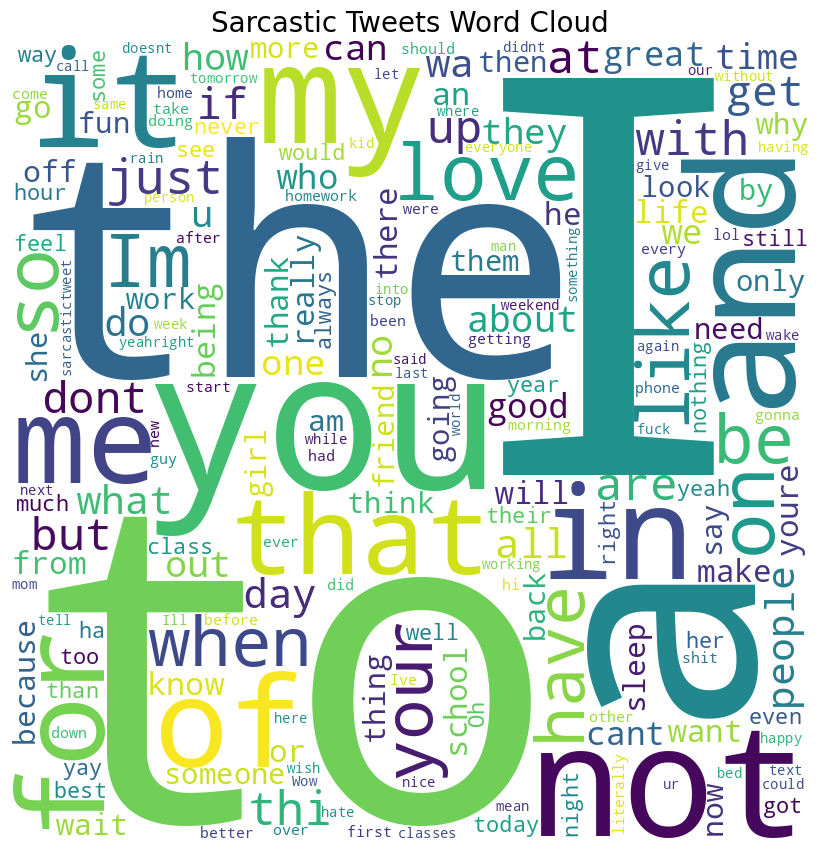

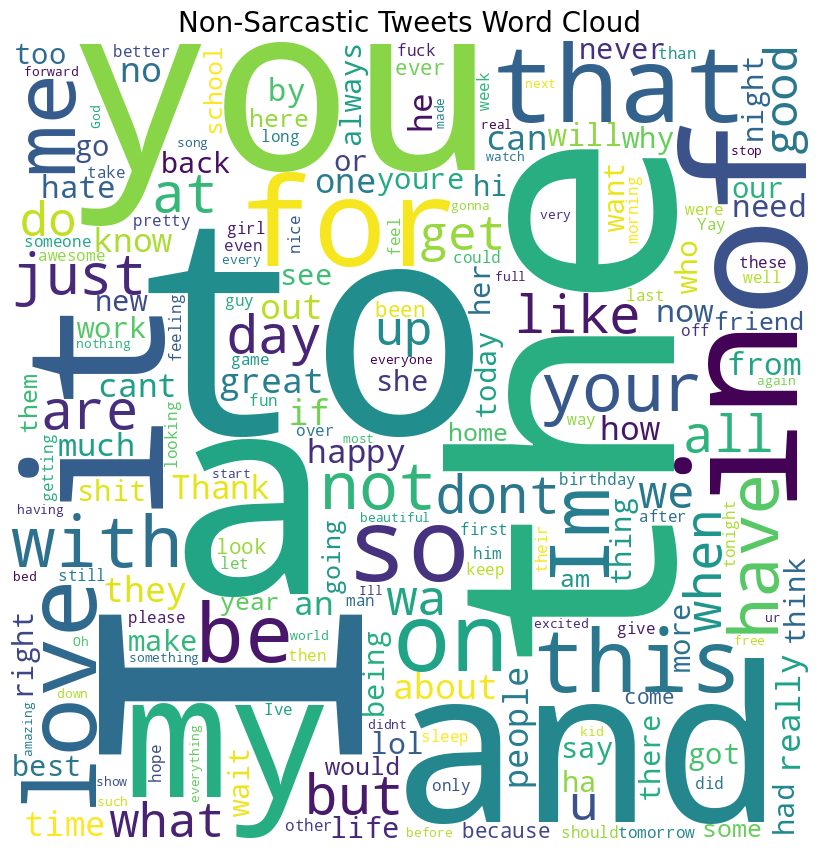

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv')
# Separate sarcastic and non-sarcastic tweets
sarcastic_tweets = df[df['label'] == 1]['text']
non_sarcastic_tweets = df[df['label'] == 0]['text']

# Function to generate word cloud
def generate_word_cloud(tweets, title):
    # Convert tweets to strings
    tweets = [str(tweet) for tweet in tweets]

    # Define custom stopwords
    custom_stopwords = set(['amp', 'https', 'co', 'rt', 'twitter'])  # Add any additional stopwords as needed

    # Generate word cloud with customized parameters
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=custom_stopwords,
                          max_words=200,
                          colormap='viridis',
                          collocations=False,
                          min_font_size=10).generate(' '.join(tweets))

    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

# Generate word cloud for sarcastic tweets
generate_word_cloud(sarcastic_tweets, 'Sarcastic Tweets Word Cloud')

# Generate word cloud for non-sarcastic tweets
generate_word_cloud(non_sarcastic_tweets, 'Non-Sarcastic Tweets Word Cloud')

# WORD CLOUD WITHOUT STOP WORDS

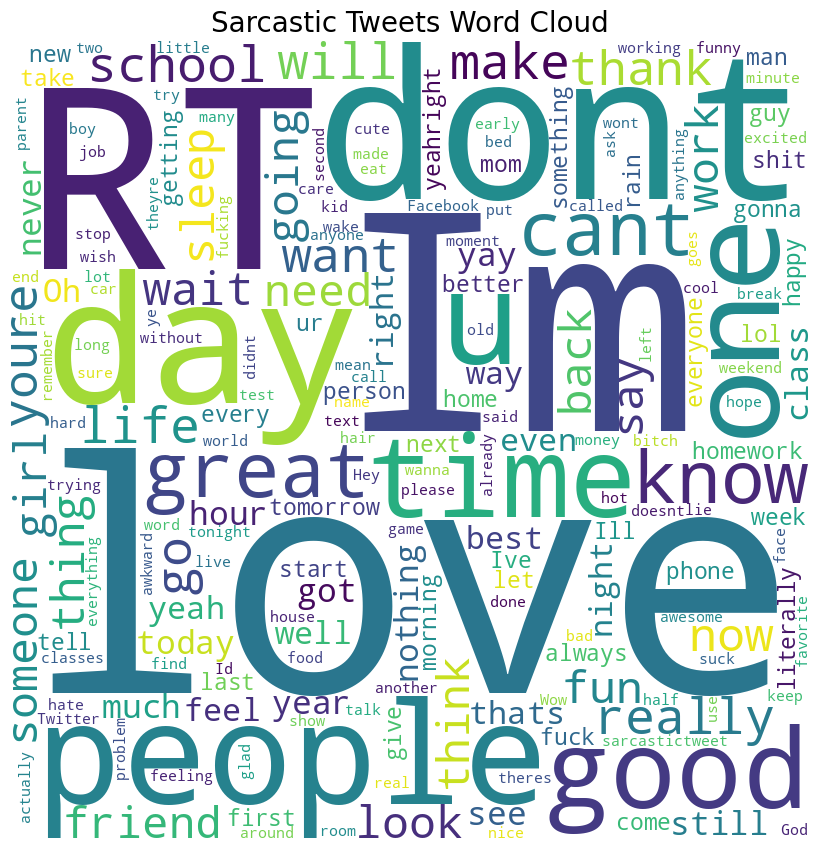

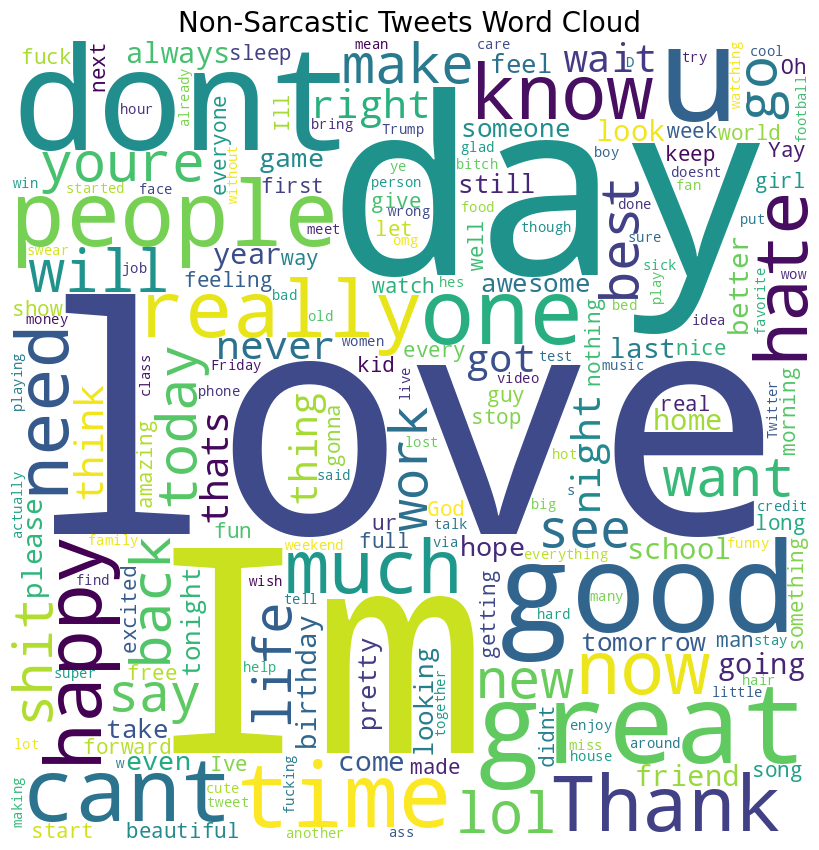

In [ ]:
import pandas as pd
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv')
# Separate sarcastic and non-sarcastic tweets
sarcastic_tweets = df[df['label'] == 1]['text']
non_sarcastic_tweets = df[df['label'] == 0]['text']

# Function to generate word cloud
def generate_word_cloud(tweets, title):
    # Convert tweets to strings
    tweets = [str(tweet) for tweet in tweets]

    # Generate word cloud without using default stopwords
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=STOPWORDS,  # Use default stopwords
                          max_words=200,
                          colormap='viridis',
                          collocations=False,
                          min_font_size=10).generate(' '.join(tweets))

    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

# Generate word cloud for sarcastic tweets
generate_word_cloud(sarcastic_tweets, 'Sarcastic Tweets Word Cloud')

# Generate word cloud for non-sarcastic tweets
generate_word_cloud(non_sarcastic_tweets, 'Non-Sarcastic Tweets Word Cloud')

# Machine Learning Model - Logistic Regression

# Logistic Regression

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Load the data
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv")

# Drop rows with missing values
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X = data['text']
y = data['label']

# Vectorize the tweets
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_vect, y)

# Predictions
y_pred = lr_model.predict(X_vect)

# Model evaluation
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')
roc_auc = roc_auc_score(y, y_pred)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC score:", roc_auc)

# Hyperparameter tuning using GridSearchCV (Optional)
param_grid = {'C': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(lr_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_vect, y)

print("Best Parameters:", grid_search.best_params_)

# Final model selection
best_lr_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_lr_model.predict(X_vect)
accuracy_best = accuracy_score(y, y_pred_best)
precision_best = precision_score(y, y_pred_best, average='weighted')
recall_best = recall_score(y, y_pred_best, average='weighted')
f1_best = f1_score(y, y_pred_best, average='weighted')
roc_auc_best = roc_auc_score(y, y_pred_best)

print("\nBest Model Evaluation:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1-score:", f1_best)
print("ROC-AUC score:", roc_auc_best)

Model Evaluation:
Accuracy: 0.8929631944987106
Precision: 0.8929505867769783
Recall: 0.8929631944987106
F1-score: 0.8929535443928832
ROC-AUC score: 0.8926636481930645
Best Parameters: {'C': 1.0}

Best Model Evaluation:
Accuracy: 0.8929631944987106
Precision: 0.8929505867769783
Recall: 0.8929631944987106
F1-score: 0.8929535443928832
ROC-AUC score: 0.8926636481930645


# Visualization

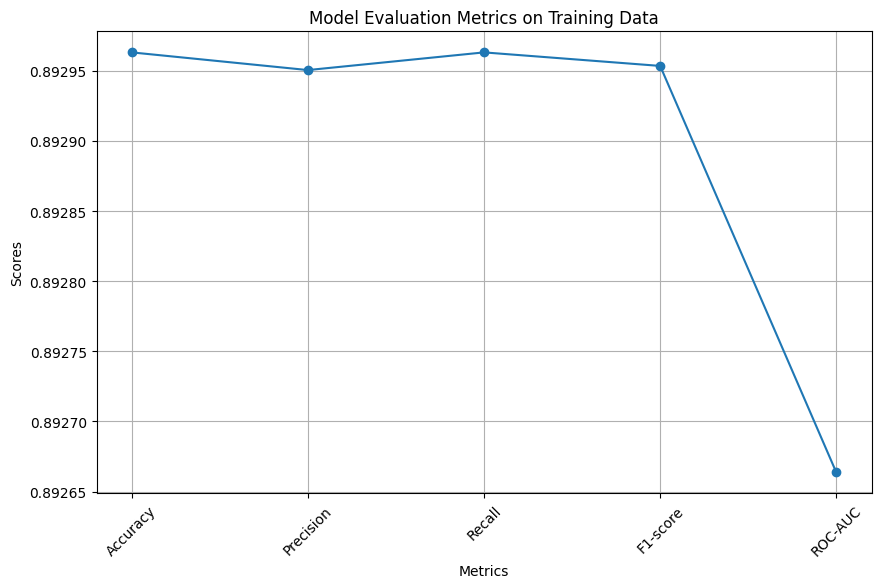

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Define evaluation metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']
scores = [accuracy, precision, recall, f1, roc_auc]

# Plot evaluation metrics
plt.figure(figsize=(10, 6))
plt.plot(metrics, scores, marker='o', linestyle='-')
plt.title('Model Evaluation Metrics on Training Data')
plt.xlabel('Metrics')
plt.ylabel('Scores')
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

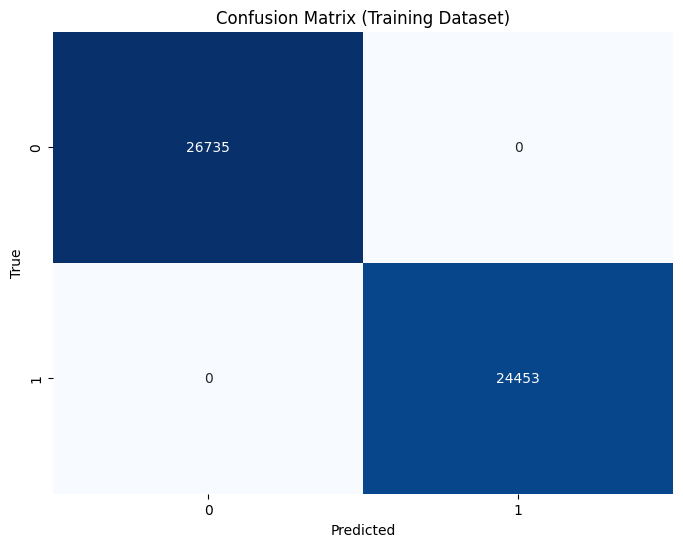

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv")

# Drop rows with missing values
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X = data['text']
y = data['label']

# Vectorize the tweets
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

# Plot confusion matrix for training dataset
def plot_confusion_matrix_train(y_true, y_pred):
    cm_train = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix (Training Dataset)')
    plt.show()

plot_confusion_matrix_train(y, y)  # Use the true labels as predictions for training dataset

# Prediction

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Load the data with only the required columns
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv", usecols=['text', 'label'])

# Drop rows with missing values in the 'tweets' column
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X = data['text']
y = data['label']  # Assuming 'label' column indicates sarcasm

# Vectorize the tweets
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

# Train Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_vect, y)

# Function for prediction
def predict_sarcasm(text):
    # Vectorize the input text
    text_vectorized = vectorizer.transform([text])

    # Predict sarcasm using the trained model
    prediction = lr_model.predict(text_vectorized)

    # Return prediction
    return "Sarcastic" if prediction[0] == 1 else "Not Sarcastic"

# Sarcastic Tweets

Only text

In [ ]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Missed the bus by a split second. Perfect timing as always!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 26ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 27ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 26ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 5: Sarcastic


Text with emoji

In [ ]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Missed the bus by a split second. Perfect timing as always! 👌🚌"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing! ⏰💰"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due. 😃🖨️"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet. 🚿🛠️"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 203ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 94ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 65ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 45ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 43ms/step
Prediction 5: Sarcastic


Text with emoji and hashtags

In [ ]:
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄 #Blessed #BestDayEver"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Missed the bus by a split second. Perfect timing as always! 👌🚌 #LuckiestPersonAlive #JustMyLuck"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Love it when my alarm goes off during a dream about winning the lottery. So refreshing! ⏰💰 #Sarcasm #DreamsComeTrue"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Oh, the joy of finding out the printer is out of ink when you have an important report due. 😃🖨️ #PrinterProblems #Fantastic"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because nothing says fun like spending the weekend fixing a leaky faucet. 🚿🛠️ #WeekendVibes #DIYQueen"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 25ms/step
Prediction 1: Sarcastic
1/1 [==============================] - 0s 27ms/step
Prediction 2: Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 3: Sarcastic
1/1 [==============================] - 0s 24ms/step
Prediction 4: Sarcastic
1/1 [==============================] - 0s 54ms/step
Prediction 5: Sarcastic


# Non-Sarcastic Tweets

Only text

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 43ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 47ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 50ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 44ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 45ms/step
Prediction 5: Not Sarcastic


Text with emoji

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life. 😊"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag.🤍"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear.💯"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 27ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 25ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 24ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 27ms/step
Prediction 5: Not Sarcastic


Text with emoji and hashtags

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life. 😊 #Gratitude #SimpleJoys"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄 #HappyMoments #JoyfulHeart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Peace of mind is the real bag.🤍 #Contentment #Satisfaction"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Everything you've ever wanted is sitting on the other side of fear.💯 #Hardwork #fearless"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃 #GoodMorning #PositiveStart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

1/1 [==============================] - 0s 43ms/step
Prediction 1: Not Sarcastic
1/1 [==============================] - 0s 39ms/step
Prediction 2: Not Sarcastic
1/1 [==============================] - 0s 39ms/step
Prediction 3: Not Sarcastic
1/1 [==============================] - 0s 38ms/step
Prediction 4: Not Sarcastic
1/1 [==============================] - 0s 44ms/step
Prediction 5: Not Sarcastic


# ***Sarcastic Tweets with simple emoji***

Only text

In [ ]:
text_to_predict = "Oh, just another thrilling Monday morning."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "When your alarm rings, and you're just thrilled to start the day."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Discovering a surprise pile of dirty dishes in the sink."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When your computer decides to freeze during a tight deadline."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because who doesn't love being stuck in traffic for hours?"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Sarcastic
Prediction 2: Sarcastic
Prediction 3: Sarcastic
Prediction 4: Sarcastic
Prediction 5: Sarcastic


Text with emoji

In [ ]:
text_to_predict = "Oh, just another thrilling Monday morning. 😒"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "When your alarm rings, and you're just thrilled to start the day."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Discovering a surprise pile of dirty dishes in the sink. 😬"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When your computer decides to freeze during a tight deadline. 😐💻"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because who doesn't love being stuck in traffic for hours? 😑🚗"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Sarcastic
Prediction 2: Sarcastic
Prediction 3: Sarcastic
Prediction 4: Sarcastic
Prediction 5: Sarcastic


Text with emoji and hashtags

In [ ]:
text_to_predict = "Oh, just another thrilling Monday morning. 😒 #MondayBlues #SoExciting"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "When your alarm rings, and you're just thrilled to start the day. ⏰😑 #EarlyBird #NotAMorningPerson"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Discovering a surprise pile of dirty dishes in the sink. 😬 #DomesticBliss #DreamComeTrue"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When your computer decides to freeze during a tight deadline. 😐💻 #Productivity #PerfectTiming"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Because who doesn't love being stuck in traffic for hours? 😑🚗 #TrafficJam #AdventureTime"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Sarcastic
Prediction 2: Sarcastic
Prediction 3: Sarcastic
Prediction 4: Sarcastic
Prediction 5: Sarcastic


# ***Non-Sarcastic Tweets***

Only text

In [ ]:
text_to_predict = "Enjoying a beautiful sunset at the beach."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just finished a great workout!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Excited for the weekend getaway with friends."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Received a surprise gift from a dear friend today."
print("Prediction 4:", prediction)
text_to_predict = "Attended an inspiring seminar on personal growth."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Not Sarcastic
Prediction 2: Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Not Sarcastic
Prediction 5: Not Sarcastic


Text with emoji

In [ ]:
text_to_predict = "Enjoying a beautiful sunset at the beach. 🌅"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just finished a great workout! 💪"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Excited for the weekend getaway with friends. 🚗🌴"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Received a surprise gift from a dear friend today. 🎁"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Attended an inspiring seminar on personal growth. 🌱"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Not Sarcastic
Prediction 2: Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Sarcastic
Prediction 5: Not Sarcastic


Text with emoji and hashtags

In [ ]:
text_to_predict = "Enjoying a beautiful sunset at the beach. 🌅 #NatureLover #SereneEvenings"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just finished a great workout! 💪 #FitnessMotivation #HealthyLiving"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Excited for the weekend getaway with friends. 🚗🌴 #WeekendAdventure #TravelGoals"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "Received a surprise gift from a dear friend today. 🎁 #GratefulHeart #Friendship"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Attended an inspiring seminar on personal growth. 🌱 #LearningJourney #SelfImprovement"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Not Sarcastic
Prediction 2: Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Sarcastic
Prediction 5: Not Sarcastic


# ***Non-Sarcastic Tweets with simple emoji***

Only text

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Reflecting on a day well spent with a satisfied grin."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When you realize it's finally Friday!"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile."
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Sarcastic
Prediction 2: Not Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Not Sarcastic
Prediction 5: Not Sarcastic


Text with emoji

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life. 😊"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Reflecting on a day well spent with a satisfied grin. 😌"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When you realize it's finally Friday! 🎉"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Sarcastic
Prediction 2: Not Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Not Sarcastic
Prediction 5: Not Sarcastic


Text with emoji and hashtags

In [ ]:
text_to_predict = "Feeling grateful for the little joys in life. 😊 #Gratitude #SimpleJoys"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 1:", prediction)
text_to_predict = "Just received good news, and my face is all smiles. 😄 #HappyMoments #JoyfulHeart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 2:", prediction)
text_to_predict = "Reflecting on a day well spent with a satisfied grin. 😌 #Contentment #Satisfaction"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 3:", prediction)
text_to_predict = "When you realize it's finally Friday! 🎉 #FriYay #WeekendVibes"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 4:", prediction)
text_to_predict = "Waking up to a sunny morning with a big cheerful smile. 😃 #GoodMorning #PositiveStart"
prediction = predict_sarcasm(text_to_predict)
print("Prediction 5:", prediction)

Prediction 1: Not Sarcastic
Prediction 2: Not Sarcastic
Prediction 3: Not Sarcastic
Prediction 4: Not Sarcastic
Prediction 5: Not Sarcastic


# Using Trainemo Dataset

# Preprocessing

1.	Removing words "sarcasm", "sarcastic", "sarcastically": Eliminates these specific words from the tweet as they may affect sentiment analysis.

2.	Removing '#' tags only keeping the word ahead of it: Removes hashtag symbols '#' from words while retaining the word itself.

3.	Removing '@' tags with the name ahead of '@': Eliminates Twitter handles (e.g., @username) from the tweet.

4.	Replacing emojis with their descriptions: Converts emojis into text descriptions to standardize their representation.

5.	Handling numbers: Removes or normalizes numerical characters in the tweet.

6.	Handling non-English alphabets: Addresses non-English characters by removing or replacing them.

7.	Handling symbols: Manages symbols, such as punctuation marks and special characters.

8.	Handling unnecessary spaces: Cleans up unnecessary whitespace in the tweet to improve readability and consistency.

9.	Counting repeated letters in each word to create a 'repetition' column: Identifies and counts repeated letters in each word, creating a feature to capture repetition patterns.

10.	Counting capital letters in each word to create a 'capital' column: Counts the number of capital letters in each word to capture emphasis or proper nouns.

11.	Calculating sentiment scores for each word using SentiWordNet: Assigns sentiment scores to words based on SentiWordNet, a lexical resource for sentiment analysis.

12.	Identifying positive and negative words based on sentiment scores: Determines whether words in the tweet have a positive or negative sentiment based on their sentiment scores.

13.	Tokenizing the tweet: Splits the tweet into individual words or tokens for further analysis.

14.	Performing parts of speech tagging on the tokenized tweet: Assigns parts of speech tags to each token to identify grammatical elements and structures within the tweet.

In [ ]:
import io
import nltk
import pandas as pd
import re
import csv
import collections
import string
import emoji
import numpy as np

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

class TweetAnalyzer:
    def __init__(self):
        # Load SentiWordNet
        self.sent_scores = self.load_senti_word_net()

    def load_senti_word_net(self):
        sent_scores = collections.defaultdict(list)
        with io.open("/content/drive/MyDrive/SentiWordNet_3.0.0_20130122.txt") as fname:
            file_content = csv.reader(fname, delimiter='\t', quotechar='"')

            for line in file_content:
                if len(line) != 6:
                    continue

                if line[0].startswith('#'):
                    continue
                pos, ID, PosScore, NegScore, synsetTerms, gloss = line
                for terms in synsetTerms.split(" "):
                    term = terms.split("#")[0]
                    term = term.replace("-", "").replace("_", "")
                    key = "%s/%s" % (pos, term.split("#")[0])
                    try:
                        sent_scores[key].append((float(PosScore), float(NegScore)))
                    except:
                        sent_scores[key].append((0, 0))

        for key, value in sent_scores.items():
            sent_scores[key] = np.mean(value, axis=0)

        return sent_scores

    def preprocess_tweet(self, tweet):
        # Preprocessing steps

        # 1. Removing words "sarcasm", "sarcastic", "sarcastically"
        tweet = re.sub(r'\bsarcasm\b|\bsarcastic\b|\bsarcastically\b', '', tweet)

        # 2. Removing '#' tags only keeping the word ahead of it
        tweet = re.sub(r'#(\w+)', r'\1', tweet)

        # 3. Removing '@' tags with the name ahead of '@'
        tweet = re.sub(r'@(\w+)', '', tweet)

        # 4. Replacing emojis with their descriptions using the emoji.demojize() function
        tweet = emoji.demojize(tweet)

        # 5. Handling numbers
        tweet = re.sub(r'\d+', '', tweet)

        # 6. Handling non-English alphabets
        tweet = re.sub(r'[^a-zA-Z\s]', '', tweet)

        # 7. Handling symbols
        tweet = re.sub(r'[^a-zA-Z0-9\s]', '', tweet)

        # 8. Handling unnecessary spaces
        tweet = re.sub(r'\s+', ' ', tweet).strip()

        # 9. Counting repeated letters in each word to create a 'repetition' column
        repetition = [sum(1 for i in range(len(word)-1) if word[i] == word[i+1]) for word in tweet.split()]

        # 10. Counting capital letters in each word to create a 'capital' column
        capital = [sum(1 for char in word if char.isupper()) for word in tweet.split()]

        # Tokenize the tweet
        tokens = nltk.word_tokenize(tweet)

        # 11. Calculating sentiment scores for each word using SentiWordNet
        sentiment_scores = [self.score_word(word) for word in tokens]

        # 12. Identifying positive and negative words based on sentiment scores
        positive_words = [word for word, (pos_score, neg_score) in zip(tokens, sentiment_scores) if pos_score > neg_score]
        negative_words = [word for word, (pos_score, neg_score) in zip(tokens, sentiment_scores) if pos_score < neg_score]

        # 13. Tokenizing the tweet
        pos_tags = nltk.pos_tag(tokens)

        return {
            'text': tweet,
            'capital': capital,
            'pos_tags': pos_tags,
            'positive_words': positive_words,
            'negative_words': negative_words,
            'sentiment_scores': sentiment_scores,
            'repetition': repetition,
        }

    def score_word(self, word):
        pos = nltk.pos_tag([word])[0][1]
        return self.score(word, pos)

    def score(self, word, pos):
        if pos[0:2] == 'NN':
            pos_type = 'n'
        elif pos[0:2] == 'JJ':
            pos_type = 'a'
        elif pos[0:2] =='VB':
            pos_type='v'
        elif pos[0:2] =='RB':
            pos_type = 'r'
        else:
            pos_type =  0

        if pos_type != 0 :
            loc = pos_type+'/'+word
            score = self.sent_scores[loc]
            if len(score)>1:
                return score
            else:
                return np.array([0.0,0.0])
        else:
            return np.array([0.0,0.0])

# Instantiate the TweetAnalyzer
tweet_analyzer = TweetAnalyzer()

encodings = ['utf-8', 'latin-1', 'iso-8859-1', 'utf-16']

# Load the CSV file
for encoding in encodings:
    try:
        df = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/Test.csv", encoding=encoding)
        print(f"CSV file successfully loaded with encoding: {encoding}")
        break  # Break the loop if successful
    except UnicodeDecodeError:
        print(f"Failed to load CSV file with encoding: {encoding}")

# Preprocess tweets
processed_tweets = []
for idx, tweet in enumerate(df['text']):
    processed_tweet = tweet_analyzer.preprocess_tweet(tweet)
    processed_tweet['label'] = df.loc[idx, 'label']
    processed_tweets.append(processed_tweet)

# Convert processed tweets to DataFrame
processed_df = pd.DataFrame(processed_tweets)

# Print completion message for all tweets preprocessing
print("Preprocessing for all tweets completed.\n")

# Tokenize the entire preprocessed tweet text again
all_tokens = nltk.word_tokenize(' '.join(processed_df['text']))

print("\n1. Removing words 'sarcasm', 'sarcastic', 'sarcastically' Completed\n2. Removing '#' tags only keeping the word ahead of it Completed\n3. Removing '@' tags with the name ahead of '@' Completed\n4. Replacing emojis with their descriptions Completed\n5. Handling numbers Completed\n6. Handling non-English alphabets Completed\n7. Handling symbols: Manages symbols, such as punctuation marks and special characters. Completed\n8. Handling unnecessary spaces Completed\n9. Counting repeated letters in each word to create a 'repetition' column Completed\n10. Counting capital letters in each word to create a 'capital' column Completed\n11. Calculating sentiment scores for each word using SentiWordNet Completed\n12. Identifying positive and negative words based on sentiment scores Completed\n13. Tokenizing the tweet: Splits the tweet into individual words or tokens for further analysis. Completed\n14. Performing parts of speech tagging on the tokenized tweet Completed")

# Save processed data to CSV
processed_df.to_csv('/content/drive/MyDrive/Labelled_Dataset/LR/LR_Test.csv', index=False)
print('Processed tweets exported')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


Failed to load CSV file with encoding: utf-8
CSV file successfully loaded with encoding: latin-1
Preprocessing for all tweets completed.


1. Removing words 'sarcasm', 'sarcastic', 'sarcastically' Completed
2. Removing '#' tags only keeping the word ahead of it Completed
3. Removing '@' tags with the name ahead of '@' Completed
4. Replacing emojis with their descriptions Completed
5. Handling numbers Completed
6. Handling non-English alphabets Completed
7. Handling symbols: Manages symbols, such as punctuation marks and special characters. Completed
8. Handling unnecessary spaces Completed
9. Counting repeated letters in each word to create a 'repetition' column Completed
10. Counting capital letters in each word to create a 'capital' column Completed
11. Calculating sentiment scores for each word using SentiWordNet Completed
12. Identifying positive and negative words based on sentiment scores Completed
13. Tokenizing the tweet: Splits the tweet into individual words or tokens for fur

# WordCloud

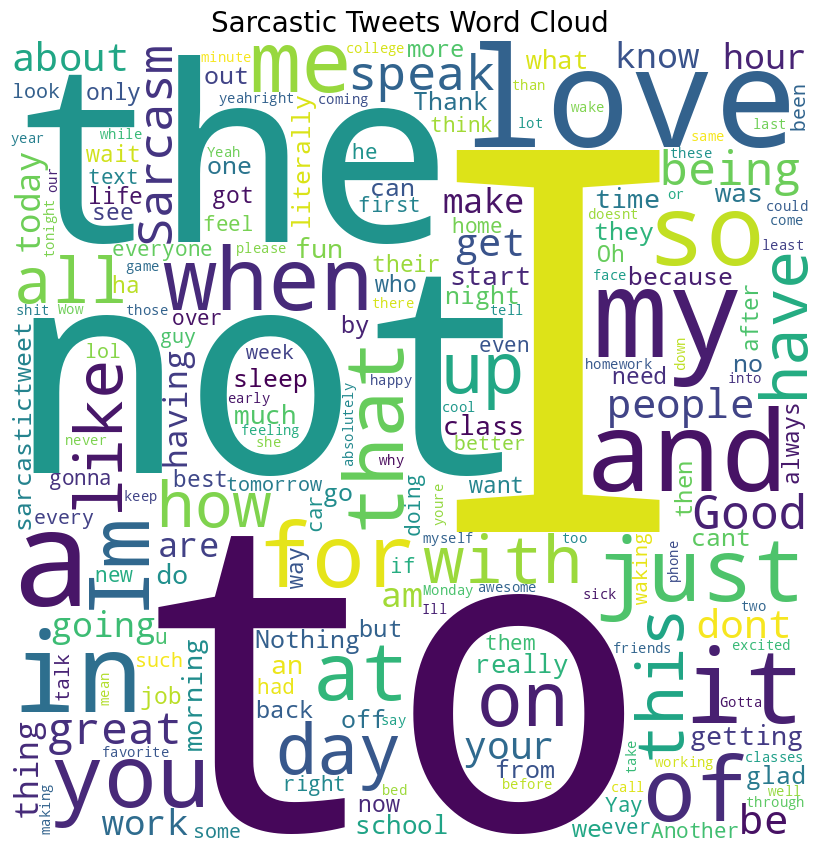

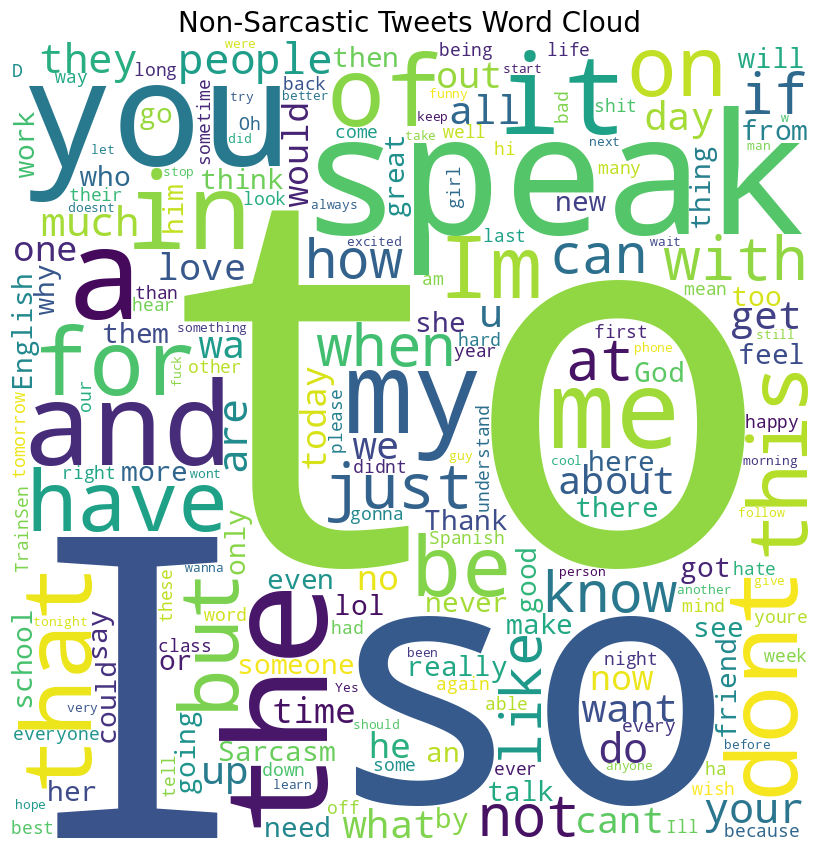

In [ ]:
import pandas as pd
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Load the CSV file into a DataFrame
df = pd.read_csv('/content/drive/MyDrive/Labelled_Dataset/LR/LR_Test.csv')
# Separate sarcastic and non-sarcastic tweets
sarcastic_tweets = df[df['label'] == 1]['text']
non_sarcastic_tweets = df[df['label'] == 0]['text']

# Function to generate word cloud
def generate_word_cloud(tweets, title):
    # Convert tweets to strings
    tweets = [str(tweet) for tweet in tweets]

    # Define custom stopwords
    custom_stopwords = set(['amp', 'https', 'co', 'rt', 'twitter'])  # Add any additional stopwords as needed

    # Generate word cloud with customized parameters
    wordcloud = WordCloud(width=800, height=800,
                          background_color='white',
                          stopwords=custom_stopwords,
                          max_words=200,
                          colormap='viridis',
                          collocations=False,
                          min_font_size=10).generate(' '.join(tweets))

    # Plot the word cloud
    plt.figure(figsize=(10, 8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.tight_layout(pad=0)
    plt.title(title, fontsize=20)
    plt.show()

# Generate word cloud for sarcastic tweets
generate_word_cloud(sarcastic_tweets, 'Sarcastic Tweets Word Cloud')

# Generate word cloud for non-sarcastic tweets
generate_word_cloud(non_sarcastic_tweets, 'Non-Sarcastic Tweets Word Cloud')

# Evaluating Model using testemo dataset

Test Set Evaluation:
Accuracy: 0.7776572668112798
Precision: 0.7919988511500078
Recall: 0.7776572668112798
F1-score: 0.7804285902098783
ROC-AUC score: 0.7833694677033493


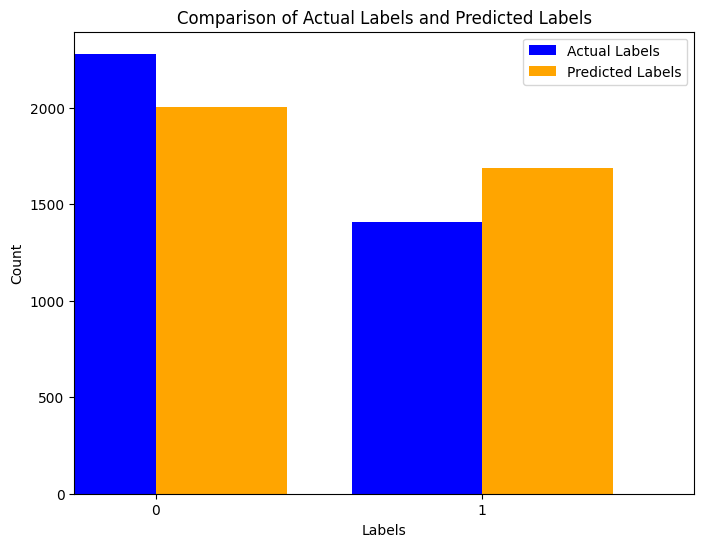

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def predict_and_evaluate(test_data, model, vectorizer):
    # Vectorize the test tweets
    X_test_vect = vectorizer.transform(test_data['text'])

    # Predict labels using the trained model
    test_data['predicted_label'] = model.predict(X_test_vect)

    # If ground truth labels are available, evaluate the model
    if 'label' in test_data.columns:
        y_test = test_data['label']
        accuracy = accuracy_score(y_test, test_data['predicted_label'])
        precision = precision_score(y_test, test_data['predicted_label'], average='weighted')
        recall = recall_score(y_test, test_data['predicted_label'], average='weighted')
        f1 = f1_score(y_test, test_data['predicted_label'], average='weighted')
        roc_auc = roc_auc_score(y_test, test_data['predicted_label'])

        print("Test Set Evaluation:")
        print("Accuracy:", accuracy)
        print("Precision:", precision)
        print("Recall:", recall)
        print("F1-score:", f1)
        print("ROC-AUC score:", roc_auc)

    # Plot accuracy comparison
    plt.figure(figsize=(8, 6))
    test_data['label'].value_counts().plot(kind='bar', color='blue', width=0.4, position=1, label='Actual Labels')
    test_data['predicted_label'].value_counts().plot(kind='bar', color='orange', width=0.4, position=0, label='Predicted Labels')
    plt.title('Comparison of Actual Labels and Predicted Labels')
    plt.xlabel('Labels')
    plt.ylabel('Count')
    plt.xticks(rotation=0)
    plt.legend()
    plt.show()

# Load the preprocessed test data
test_data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/LR_Test.csv")

# Call the function to predict, evaluate, and visualize
predict_and_evaluate(test_data, lr_model, vectorizer)

# Visuals

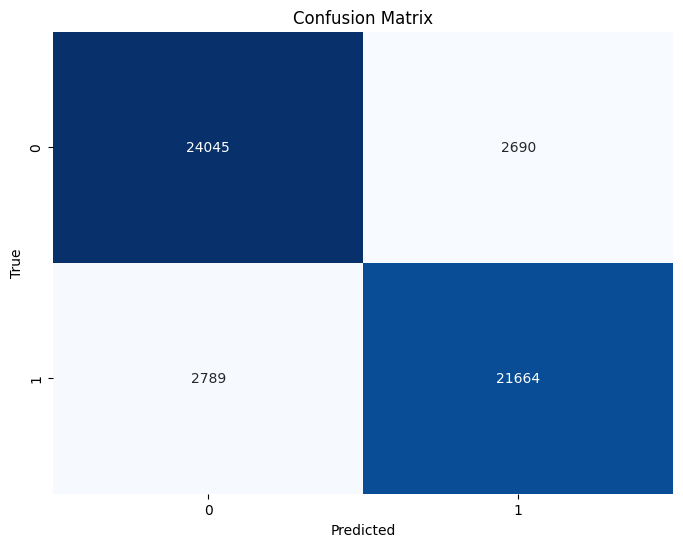

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(y, y_pred)

# Preoaring model suitable to integrate with webite

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV

# Function to train and evaluate the model
def train_and_evaluate_model(X_train, y_train):
    # Vectorize the tweets
    vectorizer = CountVectorizer()
    X_vect = vectorizer.fit_transform(X_train)

    # Train Logistic Regression model
    lr_model = LogisticRegression(max_iter=1000)
    lr_model.fit(X_vect, y_train)

    # Predictions
    y_pred = lr_model.predict(X_vect)

    # Model evaluation
    accuracy = accuracy_score(y_train, y_pred)
    precision = precision_score(y_train, y_pred, average='weighted')
    recall = recall_score(y_train, y_pred, average='weighted')
    f1 = f1_score(y_train, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_train, y_pred)

    print("Model Evaluation:")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-score:", f1)
    print("ROC-AUC score:", roc_auc)

    return vectorizer, lr_model

# Function to predict new text
def predict_new_text(vectorizer, model, new_text):
    # Vectorize the new text
    new_text_vect = vectorizer.transform([new_text])

    # Make predictions
    prediction = model.predict(new_text_vect)

    return prediction

# Load the data
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/LR_Test.csv")

# Drop rows with missing values
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X_train = data['text']
y_train = data['label']

# Train and evaluate the model
vectorizer, lr_model = train_and_evaluate_model(X_train, y_train)

Model Evaluation:
Accuracy: 0.9568872017353579
Precision: 0.9569598211795736
Recall: 0.9568872017353579
F1-score: 0.9567280219806233
ROC-AUC score: 0.9508709629186602


In [ ]:
import joblib

# Train and evaluate the model
vectorizer, lr_model = train_and_evaluate_model(X_train, y_train)

# Save the vectorizer and model as joblib files
joblib.dump(vectorizer, '/content/drive/MyDrive/Labelled_Dataset/model_files/vectorizer.joblib')
joblib.dump(lr_model, '/content/drive/MyDrive/Labelled_Dataset/model_files/lr_model.joblib')

Model Evaluation:
Accuracy: 0.9568872017353579
Precision: 0.9569598211795736
Recall: 0.9568872017353579
F1-score: 0.9567280219806233
ROC-AUC score: 0.9508709629186602


['/content/drive/MyDrive/Labelled_Dataset/model_files/lr_model.joblib']

In [ ]:
# Example of using the trained model to predict new text from a website
new_text_from_website = "This is a tweet containing sarcasm."
prediction = predict_new_text(vectorizer, lr_model, new_text_from_website)

print("\nPrediction for new text from website:", prediction)


Prediction for new text from website: [0]


# **Testing**

In [ ]:
# Input string
input_tweet = "Hey @user123, this tweet is #awesome! 😄 It's not sarcastic at all. #irony"

# Preprocess the input string
processed_tweet = tweet_analyzer.preprocess_tweet(input_tweet)

# Print the results of each preprocessing step
print("\n1. Removing words 'sarcasm', 'sarcastic', 'sarcastically':", processed_tweet['text'])
print("2. Removing '#' tags only keeping the word ahead of it:", processed_tweet['text'])
print("3. Removing '@' tags with the name ahead of '@':", processed_tweet['text'])
print("4. Replacing emojis with their descriptions:", processed_tweet['text'])
print("5. Handling numbers:", processed_tweet['text'])
print("6. Handling non-English alphabets:", processed_tweet['text'])
print("7. Handling symbols:", processed_tweet['text'])
print("8. Handling unnecessary spaces:", processed_tweet['text'])
print("9. Counting repeated letters in each word to create a 'repetition' column:", processed_tweet['repetition'])
print("10. Counting capital letters in each word to create a 'capital' column:", processed_tweet['capital'])
print("11. Calculating sentiment scores for each word using SentiWordNet:", processed_tweet['sentiment_scores'])
print("12. Identifying positive and negative words based on sentiment scores:")
print("   Positive words:", processed_tweet['positive_words'])
print("   Negative words:", processed_tweet['negative_words'])
print("13. Tokenizing the tweet:", processed_tweet['pos_tags'])

# The overall processed tweet
print("Overall Processed Tweet:", processed_tweet['text'])


1. Removing words 'sarcasm', 'sarcastic', 'sarcastically': Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
2. Removing '#' tags only keeping the word ahead of it: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
3. Removing '@' tags with the name ahead of '@': Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
4. Replacing emojis with their descriptions: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
5. Handling numbers: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
6. Handling non-English alphabets: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
7. Handling symbols: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
8. Handling unnecessary spaces: Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
9. Counting repeated letters in each word to create a 'repetition

# **Explaination**

**1. Removing words 'sarcasm', 'sarcastic', 'sarcastically':**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all

**2. Removing '#' tags only keeping the word ahead of it:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all

**3. Removing '@' tags with the name ahead of '@':**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all

**4. Replacing emojis with their descriptions:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinning face with smiling eyes Its not at all

**5. Handling numbers:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinning face with smiling eyes Its not at all

**6. Handling non-English alphabets:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinning face with smiling eyes Its not at all

**7. Handling symbols:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinning face with smiling eyes Its not at all

**8. Handling unnecessary spaces:**

   - **Original:** Hey this tweet is awesome grinningfacewithsmilingeyes Its not at all Sarcasm
   - **Result:** Hey this tweet is awesome grinning face with smiling eyes Its not at all

**9. Counting repeated letters in each word to create a 'repetition' column:**

   - **Result:** [0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0]

**10. Counting capital letters in each word to create a 'capital' column:**

   - **Result:** [1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1]

**11. Calculating sentiment scores for each word using SentiWordNet:**

   - **Result:** An array of sentiment scores for each word. Positive and negative scores are provided for each word.

**12. Identifying positive and negative words based on sentiment scores:**

   - **Positive words:** []
   - **Negative words:** ['not']

**13. Tokenizing the tweet:**

   - **Result:** A list of tuples where each tuple contains a word and its corresponding part of speech tag.

An explanation of the parts of speech in the tokenized tweet:

1. **Hey (NNP):**
   - Part of Speech: **Proper Noun**
   - Explanation: "Hey" is identified as a proper noun, representing a specific name or title.

2. **this (DT):**
   - Part of Speech: **Determiner**
   - Explanation: "This" is a determiner, specifying a particular object or group of objects.

3. **tweet (NN):**
   - Part of Speech: **Noun**
   - Explanation: "Tweet" is recognized as a noun, representing a message or post on a social media platform.

4. **is (VBZ):**
   - Part of Speech: **Verb (3rd person singular present)**
   - Explanation: "Is" is a verb in the third person singular present tense, indicating a state or condition.

5. **awesome (JJ):**
   - Part of Speech: **Adjective**
   - Explanation: "Awesome" is an adjective, describing the quality of the tweet as extremely positive.

6. **grinningfacewithsmilingeyes (NNS):**
   - Part of Speech: **Noun (Plural)**
   - Explanation: The emoji description is tokenized as a noun in plural form, likely due to its representation of multiple entities.

7. **Its (PRP$):**
   - Part of Speech: **Possessive Pronoun**
   - Explanation: "Its" is identified as a possessive pronoun, indicating ownership or association.

8. **not (RB):**
   - Part of Speech: **Adverb**
   - Explanation: "Not" is categorized as an adverb, expressing negation in this context.

9. **at (IN):**
   - Part of Speech: **Preposition**
   - Explanation: "At" functions as a preposition, indicating a location or position in relation to the tweet.

10. **all (DT):**
    - Part of Speech: **Determiner**
    - Explanation: "All" is recognized as a determiner

, emphasizing the entirety of something.

11. **Sarcasm (NNP):**
    - Part of Speech: **Proper Noun**
    - Explanation: "Sarcasm" is identified as a proper noun, likely referring to the concept or term itself.

In [ ]:
text_to_predict = "Hey @user123, this tweet is #awesome! 😄 It's not sarcastic at all. #Sarcasm"
prediction = predict_sarcasm(text_to_predict)
print("Prediction:", prediction)

Prediction: Sarcastic


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

processed_texts = processed_df['text']

# Apply stopwords removal
# You may need to customize the stop_words parameter based on your needs
stopwords_removal = CountVectorizer(stop_words='english')
X_no_stopwords = stopwords_removal.fit_transform(processed_texts)

# BoW representation
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(processed_texts)

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import GridSearchCV
from scipy.sparse import hstack

# Load the data
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv")

# Drop rows with missing values
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X = data['text']
y = data['label']

# Vectorize the tweets with stopwords removal
stopwords_removal = CountVectorizer(stop_words='english')
X_no_stopwords = stopwords_removal.fit_transform(X)

# Vectorize the tweets with Bag-of-Words representation
bow_vectorizer = CountVectorizer()
X_bow = bow_vectorizer.fit_transform(X)

# Combine the processed features horizontally
X_combined = hstack([X_no_stopwords, X_bow])

# Continue with the rest of your code
custom_model = LogisticRegression(max_iter=1000)
custom_model.fit(X_combined, y)

# Train custom model
custom_model = LogisticRegression(max_iter=1000)
custom_model.fit(X_combined, y)

# Predictions
y_pred = custom_model.predict(X_combined)

# Model evaluation
accuracy = accuracy_score(y, y_pred)
precision = precision_score(y, y_pred, average='weighted')
recall = recall_score(y, y_pred, average='weighted')
f1 = f1_score(y, y_pred, average='weighted')
roc_auc = roc_auc_score(y, y_pred)

print("Model Evaluation:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
print("ROC-AUC score:", roc_auc)

# Hyperparameter tuning using GridSearchCV (Optional)
param_grid = {'C': [0.1, 1.0, 10.0]}
grid_search = GridSearchCV(custom_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_combined, y)

print("Best Parameters:", grid_search.best_params_)

# Final model selection
best_custom_model = grid_search.best_estimator_

# Evaluate the best model
y_pred_best = best_custom_model.predict(X_combined)
accuracy_best = accuracy_score(y, y_pred_best)
precision_best = precision_score(y, y_pred_best, average='weighted')
recall_best = recall_score(y, y_pred_best, average='weighted')
f1_best = f1_score(y, y_pred_best, average='weighted')
roc_auc_best = roc_auc_score(y, y_pred_best)

print("\nBest Model Evaluation:")
print("Accuracy:", accuracy_best)
print("Precision:", precision_best)
print("Recall:", recall_best)
print("F1-score:", f1_best)
print("ROC-AUC score:", roc_auc_best)

Model Evaluation:
Accuracy: 0.910291474564351
Precision: 0.9102894054991298
Recall: 0.910291474564351
F1-score: 0.9102903718273315
ROC-AUC score: 0.910100611631229
Best Parameters: {'C': 0.1}

Best Model Evaluation:
Accuracy: 0.8510979135734937
Precision: 0.8511385438848382
Recall: 0.8510979135734937
F1-score: 0.8509977401683981
ROC-AUC score: 0.8502708145183513


In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression

# Load the data with only the required columns
data = pd.read_csv("/content/drive/MyDrive/Labelled_Dataset/LR/Processed_LR.csv", usecols=['text', 'label'])

# Drop rows with missing values in the 'tweets' column
data.dropna(subset=['text'], inplace=True)

# Extract features and target
X = data['text']
y = data['label']  # Assuming 'label' column indicates sarcasm

# Vectorize the tweets
vectorizer = CountVectorizer()
X_vect = vectorizer.fit_transform(X)

# Train Logistic Regression model
custom_model = LogisticRegression(max_iter=1000)
custom_model.fit(X_vect, y)

# Function for prediction with emojis and hashtags
def predict_sarcasm_with_emojis_and_hashtags(text):
    # Vectorize the input text
    text_vectorized = vectorizer.transform([text])

    # Predict sarcasm using the trained model
    prediction = custom_model.predict(text_vectorized)

    # Return prediction
    return "Sarcastic" if prediction[0] == 1 else "Not Sarcastic"

# ***Sarcastic Tweets***

In [ ]:
# Only text
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed!"
prediction = predict_sarcasm_with_emojis_and_hashtags(text_to_predict)
print("Prediction 1:", prediction)

# Text with emoji
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄"
prediction = predict_sarcasm_with_emojis_and_hashtags(text_to_predict)
print("Prediction 1 (with emoji):", prediction)

# Text with emoji and hashtags
text_to_predict = "Oh, another flat tire on my way to work. Just what I needed! 🙄 #Blessed #BestDayEver"
prediction = predict_sarcasm_with_emojis_and_hashtags(text_to_predict)
print("Prediction 1 (with emoji and hashtags):", prediction)

Prediction 1: Sarcastic
Prediction 1 (with emoji): Sarcastic
Prediction 1 (with emoji and hashtags): Not Sarcastic
